## 5.3 RNN 구현

![image](https://github.com/choibigo/Study/assets/38881179/0cc8d9cd-b62a-4858-9f1d-b243cf354cd7)

- 우리가 다룰 신경망은 길이가 T인 시계열 데이터를 받는다.
- 각 시각의 은닉 상태를 T개 출력한다.
- 모듈화를 위해 하나의 계층으로 표현할 수 도 있다.

![image](https://github.com/choibigo/Study/assets/38881179/3a0a2bb4-2103-4eed-a883-968215833d53)

- X0, X1, Xr-1을 묶은 Xs를 입력하면 h0, h1 hr-1을 묶은 hs를 출력하는 단일 계층으로 생각할 수 있다.
- T개의 단계분을 한꺼번에 처리하는 계층을 Time RNN 계층이라 한다.

#### 5.3.1 RNN 계층 구현
- RNN 처리를 한 단계만 수행하는 RNN 클래스 구현

![image](https://github.com/choibigo/Study/assets/38881179/3dcac932-390e-433a-9095-ec3d095270a6)

- 데이터를 미니배치로 모아 처리 한다.
- xt와 ht에는 각 샘플 데이터를 행 방향에 저장한다.

![image](https://github.com/choibigo/Study/assets/38881179/f3589e1f-88ed-48f8-a0f1-747a984aaa81)

- N: 미니배치 크기
- D: 입력 벡터의 차원수
- H: status 벡터의 차원수
- Wh: hidden state의 Feature를 뽑는 Weight
- Wx: Input의 Feature를 뽑는 Weight

#### backward

![image](https://github.com/choibigo/Study/assets/38881179/c8ed190f-22b4-4ebb-a600-c39bc0258382)

In [4]:
import numpy as np
from copy import deepcopy

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)  # tanh 미분
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)

        self.grads[0] = deepcopy(dWx)
        self.grads[1] = deepcopy(dWh)
        self.grads[2] = deepcopy(db)

        return dx, dh_prev

#### 5.3.2 Time RNN 계층 구현

![image](https://github.com/choibigo/Study/assets/38881179/ecd2f13a-cdd4-4b57-a9a9-d51ad4d99806)

- Time RNN 계층은 RNN 계층 T개를 연결한 신경마 ㅇ이다.
- Time RNN 계층은 hidden stataus(h)를 인스턴스 변수로 보관한다, 이를 통해 hidden status를 다음 볼록에 인계할 수 있다.
- 또한 hidden status를 인계 받을지에 대해 stateful이라는 변수록 조정할 수 있다.

#### backward
- 출력 쪽 층에서 전해지는 기울기를 dhs로 쓰고, 하류로 배보내는 기울기를 dxs로 사용한다.
- Turncated BPTT를 수행하기 때문에 이 블록의 이전 시각 역전파는 필요하지 않다.
- 이전 시각의 은닉 상태 기울기는 인스턴스 변수 dh에 저장해 놓는다.
- t번쨰 RNN 계층에서는 위로부터의 기울기 dht와 한시각 뒤 계층 으로부터 기울기 dhnext가 전해 진다.
- RNN의 출력은 2개로 분기 된다 분기 됬을 경우 역전파에서는 각 기울기가 합산되어 전해 진다. 따라서 RNN 계층의 최종 기울기는 합산된 기울기 (dht + dhnext)가 입력된다.

In [5]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None # 다수의 RNN 계층을 리스트로 저장하는 용도

        self.h = None # forward() 메서드를 호출 했을 때 마지막 RNN 계층의 은닉 상태를 저장한다.
        self.dh = None # backward() 메서드를 호출 했을 때 하나 앞 블록의 은닉 상태의 기울기를 저장한다.
        self.stateful = stateful # True인 이전을 출력을 고려 한다, False인 경우 앞의 출력을 고려하지 않는다. (hidden status를 영행렬로 만들어 구현)

    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # T개 분량의 시계열 데이터를 하나로 모은것, N: 미니 배치 크기, D: 입력 벡터의 차원수
        D, H = Wx.shape # H: status 의 벡터수

        self.layers = []
        hs = np.empty((N, T, H), dtype=np.float64)
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype=np.float64)
            # 첫 RNN 계층 호출시 hidden state는 0이 된다.
            # 또는 stateful 이 False (= hidden state를 사용하지 않을 때)일 떄도 hidden state가 0이 되게 하여 hidden state를 사용하지 않도록 한다.
        
        for t in range(T): # T데이터 만큼 RNN 계층 흘려주기
            layer = RNN(*self.params) # RNN layer 1개
            self.layers.append(layer) # RNN 구조를 append하여 TimeRNN 구조 만들기

            self.h = layer.forward(xs[:, t, :], self.h) # t번째 데이터에 대해서 h와 함께 RNN forward하여 다음 h 구함
            # forward() 가 호출되면, 인스턴스 변수 h는 마지막 RNN 계층의 hidden state가 저장되어 있다, 다음 forward 호출시 stateful이 True이면 기존 h를 그대로 사용한다.
            hs [:, t, :] = self.h # h들을 모아서 최종 output hs 만들기

        return hs # hidden state의 모음이 최종 output이다.
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype=np.float64)
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :]+ dh) # RNN 계층에서 backward를 계산할 때는 합산되어 계산됨
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad # RNN 계층 1개에서 나오는 grads(dWx, dWh, db) 저정
        
        for i, grad in enumerate(grads):
            self.grads # 각 RNN 계층에서 나온 grads를 모두 더함
        self.dh = dh

        return dxs

        

    


## 5.4 시계열 데이터 처리 계층 구현
- RNN을 사용한 언어 모델은 RNN Language Model(RNNLM)이다.

#### 5.4.1 RNNLM의 전체 그림

![image](https://github.com/choibigo/Study/assets/38881179/7f687ef7-7b16-499a-94d4-2a7cea6b080b)

- Embedding과 RNN 계층을 통해 Featuer를 뽑는 Representing Learning을 하고 Affine 계층과 Softmax 계층을 통해 실제 단어를 예측하는 Classifier Learning을 한다.
- 입력 벡터는 단어 ID의 배열이다 (corpus에서 각단어를 index화 한 배열)
- Affine 을통해 Softmax 이후 예측을 할때 RNN 계층 덕분에 이전 입력의 맥락을 '기억'하고 있다. (Memory가 있다.)
- 더 적확하게는 RNN은 앞선 맥락을 응집된 hidden state 벡터로 저장해 두고 있다.

#### 5.4.2 Time 계층 구현
- RNN을 한번에 처리한 TimeRNN처럼 Embedding, Timesoftmax, affine을 한번에 처리하는 TimeEmbedding, Timesoftmax, Timeaffine을 구현해야 한다.
- TimeAffine 계층은 Affine 계층 T개를 준비해서, 각 시각의 데이터를 개별적으로 처리 하면 된다, 실제로는 T개를 이용하는 방식 대신 행렬 계산으로 한번에 효율적으로 처리하는 방법으로 구현했다.
- TimeEmbedding 계층 역시 순전파 시에 T개의 Embedding 계층을 준비하고 각 Embedding 계층이 각 시각의 데이터를 처리 하면된다.

![image](https://github.com/choibigo/Study/assets/38881179/e7ce08d8-cdd5-4c41-989d-10474d87dca8)

- x0이나 x1는 아래 층에서 전해지는 예측된 점수 이며, t0이나 t1 등의 데이터는 정답 데이터 이다.
- T개의 softmax 함수가 손실을 구하고 그 손실의 평균이 최종 손실이 된다.

![image](https://github.com/choibigo/Study/assets/38881179/61eabf54-d421-4b4d-8c89-791b7a8bb5da)

## 5.5 RNNLM 학습과 평가

#### 5.5.1 RNNNLM 구현
- T개의 연속된 데이터 WS가 입력으로 주어 지고 그에 대한 정답 ts가 softmax 평가시 입력 된다 이후 최종 Loss를 구한다.

![image](https://github.com/choibigo/Study/assets/38881179/77724a41-6168-47c7-8bc4-63052196c0a8)

- xavier 초기화는 이전 계층의 노드 수에 따라 weight의 초기값이 결정된다, 표준편차가 1/sqrt(n)으로 초기화

In [6]:
import sys
sys.path.append('..')
import numpy as np
from numpy.random import randn as rn
from common.time_layers import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss

class SImpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size

        # 가중치 초기화 - Xavier 사용(=이전 계층의 노드가 n개라면 표준편차가 1/sqrt(n)의 분포로 값 초기화)
        embed_W = (rn(V, D) / 100).astype(np.float64) # 가중치는 입력(단어) 사이즈 x 압축된 벡터 크기(wordvec_size)
        
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype(np.float64) # 압축된 벡터 크기 x Hidden state 
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype(np.float64) # hidden state에 대한 weight이므로 hidden state x hidden state
        rnn_b = np.zeros(H).astype(np.float64) # rnn의 bias의 크기는 H

        affine_W = (rn(H, V) / np.sqrt(H)).astype(np.float64) # Hidden state 벡터 수 x 단어수 (최종 output: 단어에 대한 확률)
        affine_b = np.zeros(V).astype(np.float64) # Hidden state의 bias

        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), # stateful을 True로 하여 이전 TimeRNN의 hidden state를 입력으로 받을 수 있다.
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params = []
        self.grads = []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state() # RNN 신경망 초기화 메소드

#### 5.5.2 언어 모델의 평가
- 언어 모델은 주어진 과거 단어(정보)로 부터 다음에 출현할 단어의 확률분포를 출력한다.
- 이때 언어 모델의 예측 성능을 평가하는 척도로 퍼플렉서티(Perplexity)를 자주 이용한다.
- Perplexity는 간단히 말하면 '확률의 역수'이다.
- 예측한 값중 하나를 0.8로 예측 했을때 Perplexity는 1/0.8은 1.25라고 할 수 있다.
- 예측한 값중 하나를 0.2로 예측 했을때 Perplexity는 1/0.2은 5라고 할 수 있다.
- Perplexity는 작을 수록 좋다.
- 직관 적으로 '분기수(number of branch)'라고 해석할 수 있다.
- 분기수란 다음에 취할 수 있는 선택사항의 수(다음에 출현할 수 있는 단어의 후보수)를 말한다.
- 분기수(=Perplexity)가 1.25라면 다음에 출현할 수 있는 단어의 후보를 1개 정도로 좁혔다 라고 해석할 수 있다.
- 5인 경우 후보가 5개 정도로 나쁘다는 의미이다.

![image](https://github.com/choibigo/Study/assets/38881179/c62388af-0b12-481d-8c48-ebce78447288)

![image](https://github.com/choibigo/Study/assets/38881179/ef03900a-edb3-4295-8311-67598401578e)

- 단어가 여러개 일때는 위 공식에 따라 계산된다.
- N은 데이터의 총 개수이고 tn은 원핫 벡터로 나타낸 정답 레이블이다, tnk는 n개째 데이터의 k번째 값을 의미한다.
- ynk는 확률 분포로 신경망에서는 softmax의 출력이다. 사실 위 식은 Corss Entropy Loss와 동일하다
- L을 이용하여 e^L을 계산한 값이 Perplexity이다.

#### 5.5.3 RNNLM의 학습 코드
- RNNLM은 PTB 데이터셋 전부를 대상으로 학습 하면 좋은 결과를 낼 수 없기 때문에 1000개의 단어만 이용하여 학습한다.
- 크기가 작은 corpus에 대해서 실험한 값이다.
- 실제로는 현재의 모델로 큰 corpus에 대해 전혀 대응할 수 없다.
- RNN을 대체하는 LSTM과 GRU를 통해 해결할 수 있다.

Corpus 수: 1000 | 단어 수: 418
Epoch: 0 | Perplexity: 409.17374408447307
Epoch: 1 | Perplexity: 385.4177802149707
Epoch: 2 | Perplexity: 361.4966895533023
Epoch: 3 | Perplexity: 338.80736125497236
Epoch: 4 | Perplexity: 312.65689082008265
Epoch: 5 | Perplexity: 285.8228411086078
Epoch: 6 | Perplexity: 252.04867388839742
Epoch: 7 | Perplexity: 221.81750978617296
Epoch: 8 | Perplexity: 190.70588465724265
Epoch: 9 | Perplexity: 161.46667568349898
Epoch: 10 | Perplexity: 144.02679241067585
Epoch: 11 | Perplexity: 127.41324091267346
Epoch: 12 | Perplexity: 114.73381832255697
Epoch: 13 | Perplexity: 110.01580671052557
Epoch: 14 | Perplexity: 99.36049586654124
Epoch: 15 | Perplexity: 93.84352026729097
Epoch: 16 | Perplexity: 86.91299623746943
Epoch: 17 | Perplexity: 82.46143975138763
Epoch: 18 | Perplexity: 79.05714180491435
Epoch: 19 | Perplexity: 77.56835038410154
Epoch: 20 | Perplexity: 73.60635550480443
Epoch: 21 | Perplexity: 68.09966851722463
Epoch: 22 | Perplexity: 65.67561852164431
Epoch:

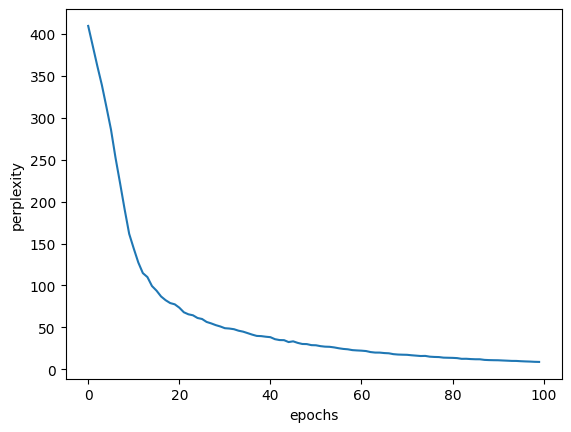

In [16]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from data_set import ptb

# Hyperparameter
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN Hidden state 벡터의 수
time_size = 5 # Truncated BPTT가 한번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 입력 ( 마지막 단어는 제외 있어도 필요 없음)
ts = corpus[1:] # 출력된 데이터와 비교할 정답 데이터
data_size = len(xs)
print(f"Corpus 수: {corpus_size} | 단어 수: {vocab_size}")

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SImpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 미니배치에서 샘플을 읽기 시작한 위치 계산
# 이 offset의 각 원소에 데이터를 읽는 시작 위치가 담기게 된다.
jump = (corpus_size-1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 확득
        # 데이터를 순차 적으로 읽는다.
        batch_x = np.empty((batch_size, time_size), dtype=np.int32)
        batch_t = np.empty((batch_size, time_size), dtype=np.int32)

        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = xs[(offset + time_idx) % data_size]
            time_idx += 1

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print(f"Epoch: {epoch} | Perplexity: {ppl}")
    ppl_list.append(float(ppl))
    total_loss = 0
    loss_count = 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()